In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import PandasTools, rdMolDescriptors, rdFingerprintGenerator, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize 
from math import log10
from collections import defaultdict

RDLogger.DisableLog('rdApp.*') #Disable RDKit notifications for smiles standardization

In [2]:
org_df = pd.read_csv('EGFR_Chembl_raw.csv', sep = ';')
org_df.shape

C:\Users\Tim\AppData\Local\Temp\ipykernel_10880\204613330.py:1: DtypeWarning: Columns (3,4,5,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  org_df = pd.read_csv('EGFR_Chembl_raw.csv', sep = ';')


(16715, 46)

In [3]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          16715 non-null  object 
 1   Molecule Name               2246 non-null   object 
 2   Molecule Max Phase          16715 non-null  object 
 3   Molecular Weight            16715 non-null  object 
 4   #RO5 Violations             16715 non-null  object 
 5   AlogP                       16715 non-null  object 
 6   Compound Key                16715 non-null  object 
 7   Smiles                      16683 non-null  object 
 8   Standard Type               16715 non-null  object 
 9   Standard Relation           15336 non-null  object 
 10  Standard Value              15336 non-null  float64
 11  Standard Units              15478 non-null  object 
 12  pChEMBL Value               11990 non-null  float64
 13  Data Validity Comment       367

<Axes: >

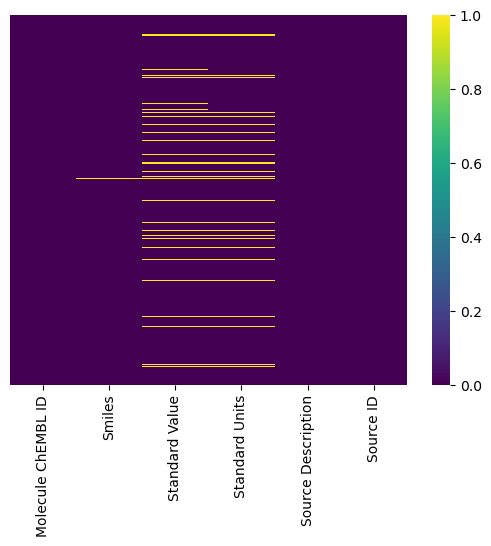

In [4]:
sns.heatmap(org_df.isnull()[['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units', 'Source Description', 'Source ID']],cbar=True,yticklabels=False,cmap = 'viridis')

<Axes: >

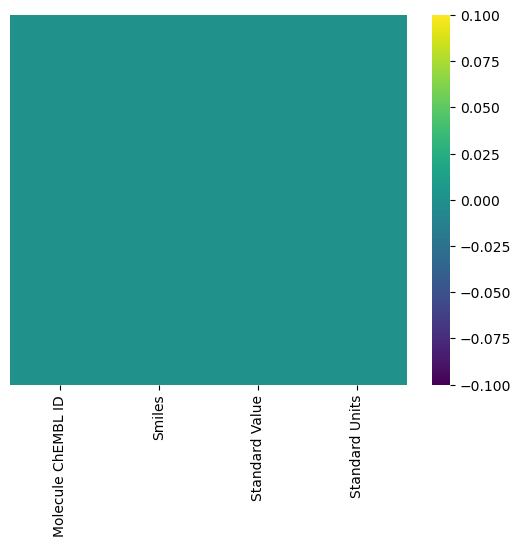

In [5]:
org_df.dropna(axis = 0, subset = ['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units', 'Source Description', 'Source ID'], inplace = True)
sns.heatmap(org_df.isnull()[['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units']],cbar=True,yticklabels=False,cmap = 'viridis')

In [6]:
org_df['Data Validity Comment'].unique()

array([nan, 'Outside typical range', 'Potential transcription error'],
      dtype=object)

In [7]:
org_df.fillna(value = {'Data Validity Comment':'No Comment'}, inplace = True)
org_df = org_df[org_df['Data Validity Comment'] == 'No Comment']
org_df.shape

(14962, 46)

In [8]:
org_df['Standard Units'].unique()

array(['nM', 'ug.mL-1', '/uM', 'µM'], dtype=object)

In [9]:
org_df = org_df[(org_df['Standard Units'] == 'nM') | (org_df['Standard Units'] == 'ug.mL-1') | (org_df['Standard Units'] == 'µM')]
org_df['Standard Units'].unique()

array(['nM', 'ug.mL-1', 'µM'], dtype=object)

In [10]:
org_df['Source Description'].unique()

array(['Scientific Literature', 'Patent Bioactivity Data',
       'BindingDB Database', 'DrugMatrix',
       'Donated Chemical Probes - SGC Frankfurt',
       'Literature data from EUbOPEN Chemogenomic Library'], dtype=object)

In [11]:
org_df = org_df[org_df['Standard Relation'] == "'='"]
org_df.shape

(11983, 46)

In [12]:
for i in list(org_df.index):
    if org_df.loc[i,'Standard Units'] == 'nM':
        ic50_M = 10**-9 * float(org_df.loc[i,'Standard Value'])
    elif org_df.loc[i,'Standard Units'] == 'µM':
        ic50_M =  10**-6 * float(org_df.loc[i,'Standard Value'])
    else:
        ic50_M = float(org_df.loc[i,'Standard Value'])/float(org_df.loc[i,'Molecular Weight']) * 10**-3
    
    org_df.loc[i,'pIC50'] = -log10(ic50_M)
    
org_df['pIC50'] = org_df['pIC50'].round(4)
org_df['pIC50'].describe()

count    11983.000000
mean         6.945576
std          1.360156
min          3.647900
25%          5.944900
50%          7.000000
75%          7.984450
max         11.000000
Name: pIC50, dtype: float64

<Axes: ylabel='Frequency'>

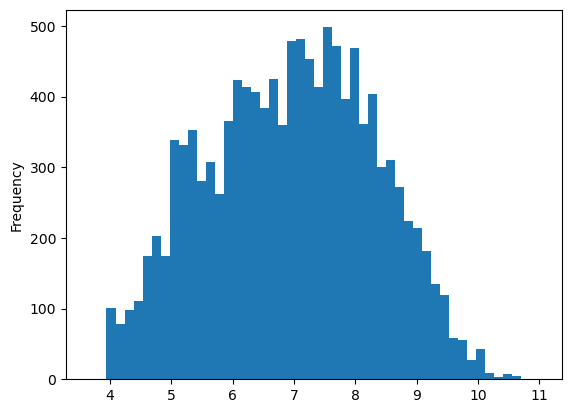

In [13]:
org_df['pIC50'].plot.hist(bins=50)

In [ ]:
for i in org_df.index:
    smi = org_df.loc[i,'Smiles']
    try:
        std_smi = rdMolStandardize.StandardizeSmiles(smi)
        org_df.loc[i,'Standardized Smiles'] = std_smi
    except:
        pass

In [ ]:
PandasTools.AddMoleculeColumnToFrame(org_df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

Need to check for duplicate molecules.

In [ ]:
org_df.loc[45,'Molecule']

In [ ]:
mol_len = org_df.shape[0]
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
fps = [fpgen.GetFingerprint(x) for x in org_df['Molecule']]

In [ ]:
sim_array = []
for i in range(mol_len):
    sims = i*[0] + DataStructs.BulkTanimotoSimilarity(fps[i],fps[i:])
    sim_array.append(sims)
    
sim_array = np.array(sim_array)

In [ ]:
org_df.reset_index(drop = True, inplace = True)
sim_df = pd.DataFrame(data = sim_array.T)

In [ ]:
repeats = {}
total = 0
for x in range(mol_len):
    repeat_num = list(sim_df[sim_df[x] == 1].index)
    if len(repeat_num) > 1:
        repeats[f'molecule_{x}'] = list(sim_df[sim_df[x] == 1].index)
        total += len(repeat_num)
    
len(repeats.keys()), total

In [ ]:
structs = org_df.loc[repeats['molecule_20'], 'Molecule']
acts = org_df.loc[repeats['molecule_20'], 'pIC50'].astype('str').tolist()
Draw.MolsToGridImage(structs, subImgSize = (300,300), legends = acts)

In [ ]:
org_df[['Standardized Smiles','Standard Value','Standard Units']].to_csv('EGFR_Chembl_clean.csv', index = False)